In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import torch
from torch.utils.data import random_split, DataLoader
import datasets
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification
)
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from src.active.strategies import BadgeForSequenceClassification
from src.active.utils.engines import Trainer
from src.active.utils.schedulers import LinearWithWarmup
from src.active.utils.params import TransformerParameterGroups
from scripts.al_seq_cls import prepare_seq_cls_datasets

## Preparation

In [3]:
# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# load and prepare dataset
ds = datasets.load_dataset('trec', split={'train': 'train'})
ds = prepare_seq_cls_datasets(ds, tokenizer, max_length=64, label_column='label-coarse')
pool = ds['train']
num_labels = len(pool.info.features['labels'].names)

Using custom data configuration default
Reusing dataset trec (/home/stud/doll0/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/stud/doll0/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9/cache-ff6db2d8c5459361.arrow


In [4]:
# load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
# create optimizer and more
params = TransformerParameterGroups(model, lr=2e-5, lr_decay=0.975, weight_decay=0.01)
optim = torch.optim.AdamW(params)
scheduler = LinearWithWarmup(optim, warmup_proportion=0.1)
# create trainer
trainer = Trainer(model, optim, scheduler, incremental=True)
ProgressBar().attach(trainer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Early Stages of Training

In [5]:
n = 50
# random split training data from pool
train, pool = random_split(pool, lengths=[n, len(pool) - n])
train_loader = DataLoader(train, batch_size=8, shuffle=True)
# train
_ = trainer.run(train_loader, max_epochs=5)

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

In [6]:
# create strategy and attach progress bar
strategy = BadgeForSequenceClassification(model.bert, model.classifier)
ProgressBar().attach(strategy)
# query strategy
_ = strategy.query(pool, query_size=25, batch_size=16)

[1/338]   0%|           [00:00<?]

In [7]:
# plot strategy embeddings and selection
idx = strategy.selected_indices
# dimensionality reduction
X = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='random'
).fit_transform(
    X=strategy.output
)

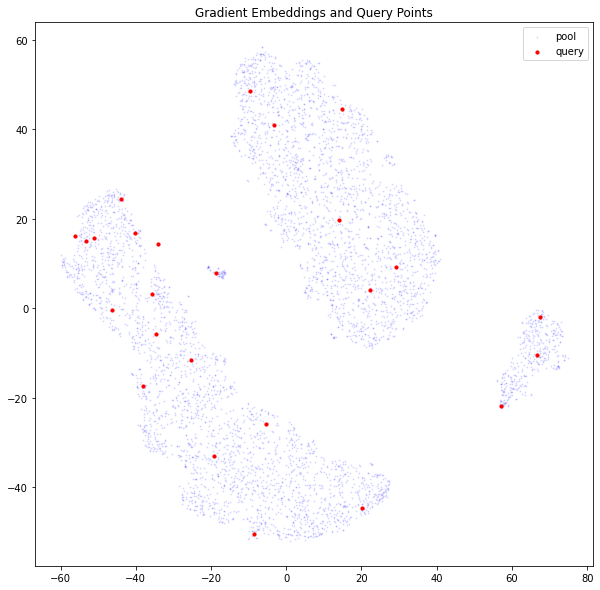

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=1.0, color='blue', alpha=0.1)
ax.scatter(X[idx, 0], X[idx, 1], s=10.0, color='red', alpha=1.0)
ax.legend(['pool', 'query'])
ax.set(title="Gradient Embeddings and Query Points")
plt.show()

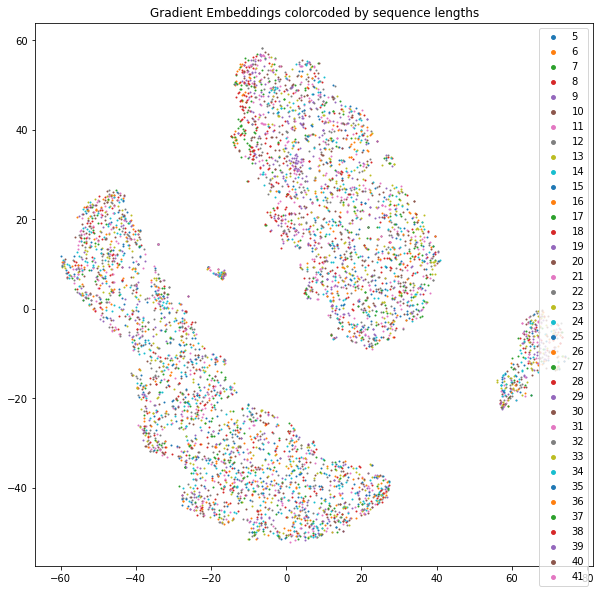

In [9]:
attention_masks = torch.stack([e['attention_mask'] for e in pool], dim=0)
lengths = attention_masks.sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=None if l > 0 else 'red',
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Gradient Embeddings colorcoded by sequence lengths")
# all done
plt.show()

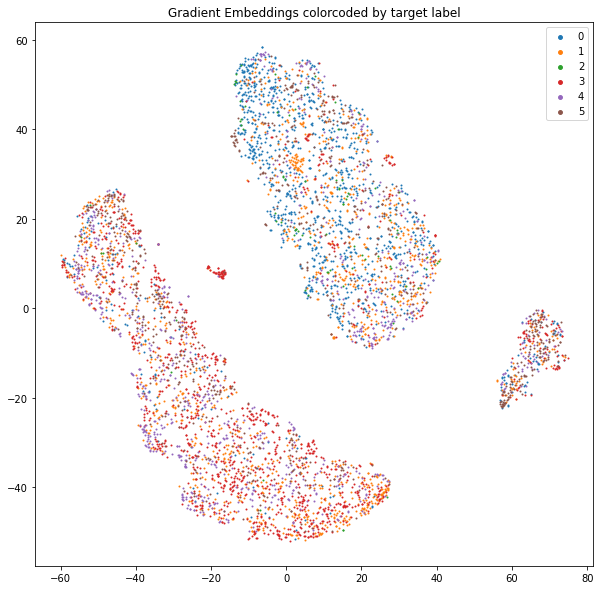

In [10]:
labels = torch.LongTensor([e['labels'] for e in pool])
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for i in range(num_labels):
    mask = (labels == i)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        label=i
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Gradient Embeddings colorcoded by target label")
# all done
plt.show()

## Later Stages of Training

In [11]:
n = 750
# random split training data from pool
train, pool = random_split(pool, lengths=[n, len(pool) - n])
train_loader = DataLoader(train, batch_size=8, shuffle=True)
# train model
_ = trainer.run(train_loader, max_epochs=5)

[1/94]   1%|1          [00:00<?]

[1/94]   1%|1          [00:00<?]

[1/94]   1%|1          [00:00<?]

[1/94]   1%|1          [00:00<?]

[1/94]   1%|1          [00:00<?]

In [12]:
# create strategy and attach progress bar
strategy = BadgeForSequenceClassification(model.bert, model.classifier)
ProgressBar().attach(strategy)
# query strategy
_ = strategy.query(pool, query_size=25, batch_size=16)

[1/291]   0%|           [00:00<?]

In [13]:
# plot strategy embeddings and selection
idx = strategy.selected_indices
# dimensionality reduction
X = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='random'
).fit_transform(
    X=strategy.output
)

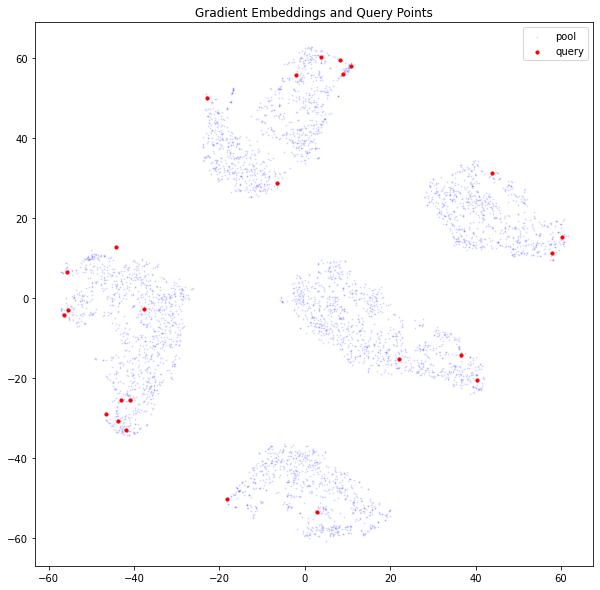

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], s=1.0, color='blue', alpha=0.1)
ax.scatter(X[idx, 0], X[idx, 1], s=10.0, color='red', alpha=1.0)
ax.legend(['pool', 'query'])
ax.set(title="Gradient Embeddings and Query Points")
plt.show()

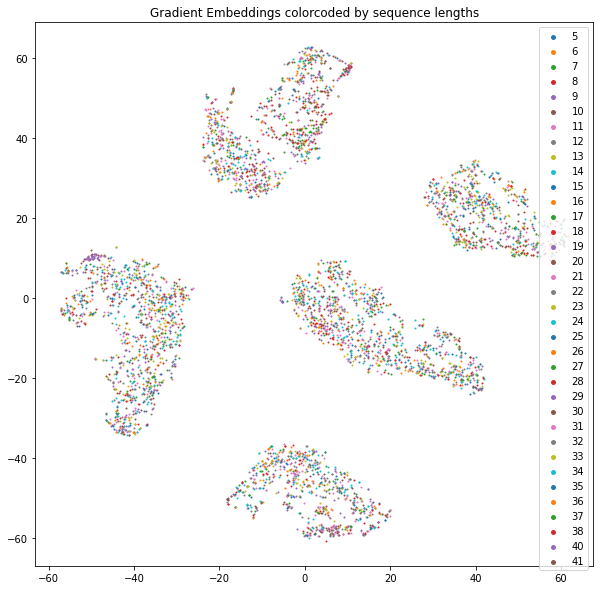

In [15]:
attention_masks = torch.stack([e['attention_mask'] for e in pool], dim=0)
lengths = attention_masks.sum(dim=-1)
uniques = lengths.unique()
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for l in uniques:
    mask = (lengths == l)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        color=None if l > 0 else 'red',
        label=l.item()
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Gradient Embeddings colorcoded by sequence lengths")
# all done
plt.show()

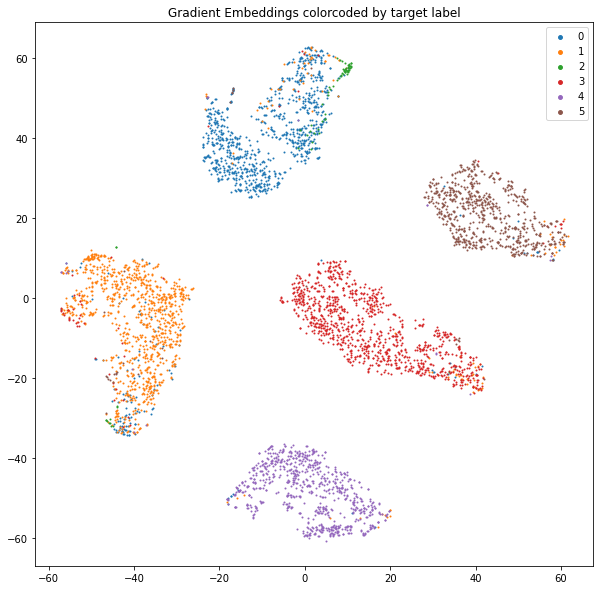

In [16]:
labels = torch.LongTensor([e['labels'] for e in pool])
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot
for i in range(num_labels):
    mask = (labels == i)
    ax.scatter(X[mask, 0], X[mask, 1], 
        s=1.0, 
        alpha=1.0,
        label=i
    )
# set legend
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([15])
ax.set(title="Gradient Embeddings colorcoded by target label")
# all done
plt.show()